In [ ]:
#####################################################################################
## Project: macaque SP brain                                                       ##
## Script Purpose: create DAP pipeline using DESeq2 and Wilcox                     ##
## Data: 2022.11.03                                                                ##
## Author: Yiming Sun                                                              ##
#####################################################################################

#sleep
ii <- 1
while(1){
  cat(paste("round",ii),sep = "\n")
  ii <- ii+1
  Sys.sleep(30)
}

In [ ]:
#general setting
setwd('/content/data/sunym/project/Brain')
.libPaths('/home/sunym/env/R_4.2.1/lib/R/library')
Sys.setenv(HDF5_USE_FILE_LOCKING=FALSE,RHDF5_USE_FILE_LOCKING=FALSE)

#library
library(Rmisc)
library(Seurat)
library(ggplot2)
library(dplyr)
library(scibet)
library(Matrix)
library(tidyverse)
library(cowplot)
library(viridis)
library(ComplexHeatmap)
library(parallel)
library(ggsignif)
library(RColorBrewer)
library(ggsci)
library(scales)
library(patchwork)
library(ggpointdensity)
library(latex2exp)
library(ArchR)
library(scales)
library(circlize)
library(ggpubr)
library(ggtext)
library(BSgenome.Hsapiens.UCSC.hg38)
library(BSgenome.Mmulatta.UCSC.rheMac10)
library(UpSetR)
library(ggbreak)
library(ggvenn)
library(EnrichedHeatmap)
library(ChIPseeker)
library(org.Hs.eg.db)
library(org.Mmu.eg.db)
library(DESeq2)
library(topGO)
library(clusterProfiler)

#my function
source('https://raw.githubusercontent.com/yimingsun12138/source_list/main/sc_multiomics.R')
source('https://raw.githubusercontent.com/yimingsun12138/source_list/main/genomics.R')
source('/content/script/twilio_send_messages.R')

#initialize ArchR
addArchRThreads(threads = 5)

## Using DESeq2 method

In [ ]:
#load data
Brain_ATAC_peak <- readRDS(file = './res/step_73_fig_221102/Brain_ATAC_peak.rds')
human_peak_matrix <- readRDS(file = './res/step_73_fig_221102/human_peak_matrix.rds')
macaque_peak_matrix <- readRDS(file = './res/step_73_fig_221102/macaque_peak_matrix.rds')
mouse_peak_matrix <- readRDS(file = './res/step_73_fig_221102/mouse_peak_matrix.rds')

In [ ]:
Greenleaf_ATAC_ArchR <- loadArchRProject(path = './processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/')
macaque_multiome_ArchR <- loadArchRProject(path = './processed_data/221008_summary/macaque_multiome_ArchR_221011/')
mouse_multiome_ArchR <- loadArchRProject(path = './processed_data/221008_summary/mouse_multiome_ArchR_221009/')

### IP as example

In [ ]:
#IP as example
cell_type <- 'IP'
cell_type_dot <- gsub(pattern = '-',replacement = '.',x = cell_type,fixed = TRUE)

In [ ]:
#create human pseudobulk
cell_list <- rownames(Greenleaf_ATAC_ArchR@cellColData)[c(Greenleaf_ATAC_ArchR$cell_type == cell_type)]
temp_num <- round(length(cell_list)/3)
cell_list <- split(x = cell_list,f = sample(c(rep('rep_1',times = temp_num),rep('rep_2',times = temp_num),rep('rep_3',times = length(cell_list) - 2*temp_num))))
human_cell_list <- cell_list

In [ ]:
human_pseudo_bulk <- base::do.call(what = cbind,args = base::lapply(X = c('rep_1','rep_2','rep_3'),FUN = function(x){
    temp <- cell_list[[x]]
    temp <- rowSums(human_peak_matrix[,temp])
    return(temp)
}))
rownames(human_pseudo_bulk) <- rownames(human_peak_matrix)
colnames(human_pseudo_bulk) <- paste('human',cell_type_dot,c('rep_1','rep_2','rep_3'),sep = '#')

In [ ]:
#create macaque pseudo bulk
cell_list <- rownames(macaque_multiome_ArchR@cellColData)[c(macaque_multiome_ArchR$cell_type == cell_type)]
temp_num <- round(length(cell_list)/3)
cell_list <- split(x = cell_list,f = sample(c(rep('rep_1',times = temp_num),rep('rep_2',times = temp_num),rep('rep_3',times = length(cell_list) - 2*temp_num))))
macaque_cell_list <- cell_list

In [ ]:
macaque_pseudo_bulk <- base::do.call(what = cbind,args = base::lapply(X = c('rep_1','rep_2','rep_3'),FUN = function(x){
    temp <- cell_list[[x]]
    temp <- rowSums(macaque_peak_matrix[,temp])
    return(temp)
}))
rownames(macaque_pseudo_bulk) <- rownames(macaque_peak_matrix)
colnames(macaque_pseudo_bulk) <- paste('macaque',cell_type_dot,c('rep_1','rep_2','rep_3'),sep = '#')

In [ ]:
#create mouse pseudo bulk
cell_list <- rownames(mouse_multiome_ArchR@cellColData)[c(mouse_multiome_ArchR$Gex_macaque_cell_type == cell_type)]
temp_num <- round(length(cell_list)/3)
cell_list <- split(x = cell_list,f = sample(c(rep('rep_1',times = temp_num),rep('rep_2',times = temp_num),rep('rep_3',times = length(cell_list) - 2*temp_num))))
mouse_cell_list <- cell_list

In [ ]:
mouse_pseudo_bulk <- base::do.call(what = cbind,args = base::lapply(X = c('rep_1','rep_2','rep_3'),FUN = function(x){
    temp <- cell_list[[x]]
    temp <- rowSums(mouse_peak_matrix[,temp])
    return(temp)
}))
rownames(mouse_pseudo_bulk) <- rownames(mouse_peak_matrix)
colnames(mouse_pseudo_bulk) <- paste('mouse',cell_type_dot,c('rep_1','rep_2','rep_3'),sep = '#')

In [ ]:
#create pseudobulk counts matrix
#macaque
temp <- Brain_ATAC_peak$macaque
names(temp) <- paste(temp@seqnames,as.character(temp@ranges),sep = '-')
rownames(macaque_pseudo_bulk) <- temp[c(rownames(macaque_pseudo_bulk))]$name
macaque_pseudo_bulk <- macaque_pseudo_bulk[c(rownames(human_pseudo_bulk)),]

#mouse
temp <- Brain_ATAC_peak$mouse
names(temp) <- paste(temp@seqnames,as.character(temp@ranges),sep = '-')
rownames(mouse_pseudo_bulk) <- temp[c(rownames(mouse_pseudo_bulk))]$name
mouse_pseudo_bulk <- mouse_pseudo_bulk[c(rownames(human_pseudo_bulk)),]

In [ ]:
#filter peak list

#human peak list
peak_file <- list.files(path = './processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls',peak_file,sep = '/')
file.exists(peak_file)
peak_file <- readRDS(file = peak_file)

temp <- Brain_ATAC_peak$human
names(temp) <- paste(temp@seqnames,as.character(temp@ranges),sep = '-')
temp_num <- countOverlaps(query = temp,subject = peak_file)
temp <- temp[names(temp_num)[c(temp_num > 0)]]

peak_list <- names(temp)

#macaque peak list
peak_file <- list.files(path = './processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls',peak_file,sep = '/')
file.exists(peak_file)
peak_file <- readRDS(file = peak_file)

temp <- Brain_ATAC_peak$macaque
names(temp) <- paste(temp@seqnames,as.character(temp@ranges),sep = '-')
temp_num <- countOverlaps(query = temp,subject = peak_file)
temp <- temp[names(temp_num)[c(temp_num > 0)]]

peak_list <- c(peak_list,temp$name)

#mouse peak list
peak_file <- list.files(path = './processed_data/221008_summary/mouse_multiome_ArchR_221009/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/mouse_multiome_ArchR_221009/PeakCalls',peak_file,sep = '/')
file.exists(peak_file)
peak_file <- readRDS(file = peak_file)

temp <- Brain_ATAC_peak$mouse
names(temp) <- paste(temp@seqnames,as.character(temp@ranges),sep = '-')
temp_num <- countOverlaps(query = temp,subject = peak_file)
temp <- temp[names(temp_num)[c(temp_num > 0)]]

peak_list <- c(peak_list,temp$name)

#unique peak_list
peak_list <- unique(peak_list)

In [ ]:
#DESeq2

#human macaque
dds_HR <- cbind(human_pseudo_bulk,macaque_pseudo_bulk)
dds_HR <- dds_HR[c(peak_list),]
dds <- dds_HR
meta_data <- do.call(what = cbind,args = base::lapply(X = c(1,2,3),FUN = function(x){
    temp <- strsplit(x = colnames(dds),split = '#')
    temp <- do.call(what = rbind,args = temp)
    return(temp[,x])
}))

rownames(meta_data) <- colnames(dds)
colnames(meta_data) <- c('species','cell_type','sample')

dds_HR <- DESeqDataSetFromMatrix(countData = dds,colData = meta_data,design = ~ species)
dds_HR <- DESeq(object = dds_HR)

#human mouse
dds_HM <- cbind(human_pseudo_bulk,mouse_pseudo_bulk)
dds_HM <- dds_HM[c(peak_list),]
dds <- dds_HM
meta_data <- do.call(what = cbind,args = base::lapply(X = c(1,2,3),FUN = function(x){
    temp <- strsplit(x = colnames(dds),split = '#')
    temp <- do.call(what = rbind,args = temp)
    return(temp[,x])
}))

rownames(meta_data) <- colnames(dds)
colnames(meta_data) <- c('species','cell_type','sample')

dds_HM <- DESeqDataSetFromMatrix(countData = dds,colData = meta_data,design = ~ species)
dds_HM <- DESeq(object = dds_HM)

#macaque mouse
dds_RM <- cbind(macaque_pseudo_bulk,mouse_pseudo_bulk)
dds_RM <- dds_RM[c(peak_list),]
dds <- dds_RM
meta_data <- do.call(what = cbind,args = base::lapply(X = c(1,2,3),FUN = function(x){
    temp <- strsplit(x = colnames(dds),split = '#')
    temp <- do.call(what = rbind,args = temp)
    return(temp[,x])
}))

rownames(meta_data) <- colnames(dds)
colnames(meta_data) <- c('species','cell_type','sample')

dds_RM <- DESeqDataSetFromMatrix(countData = dds,colData = meta_data,design = ~ species)
dds_RM <- DESeq(object = dds_RM)

In [ ]:
#human specific
res_HR <- results(object = dds_HR,contrast = c('species','human','macaque'))
res_HR <- na.omit(res_HR)
res_HR <- res_HR[res_HR$log2FoldChange > 1 & res_HR$padj < 0.01,]

res_HM <- results(object = dds_HM,contrast = c('species','human','mouse'))
res_HM <- na.omit(res_HM)
res_HM <- res_HM[res_HM$log2FoldChange > 1 & res_HM$padj < 0.01,]

human_specific_peak <- dplyr::intersect(x = rownames(res_HR),y = rownames(res_HM))

#intersect with human peaklist
peak_file <- list.files(path = './processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls',peak_file,sep = '/')
file.exists(peak_file)
peak_file <- readRDS(file = peak_file)
temp <- Brain_ATAC_peak$human
names(temp) <- paste(temp@seqnames,as.character(temp@ranges),sep = '-')
temp_num <- countOverlaps(query = temp[c(human_specific_peak)],subject = peak_file)
human_specific_peak <- human_specific_peak[c(temp_num > 0)]

ii <- rep('human_specific',times = length(human_specific_peak))
names(ii) <- human_specific_peak
group <- ii

In [ ]:
#human macaque conserved
res_HM <- results(object = dds_HM,contrast = c('species','human','mouse'))
res_HM <- na.omit(res_HM)
res_HM <- res_HM[res_HM$log2FoldChange > 1 & res_HM$padj < 0.01,]

res_RM <- results(object = dds_RM,contrast = c('species','macaque','mouse'))
res_RM <- na.omit(res_RM)
res_RM <- res_RM[res_RM$log2FoldChange > 1 & res_RM$padj < 0.01,]

res_HR <- results(object = dds_HR,contrast = c('species','human','macaque'))
res_HR <- na.omit(res_HR)
res_HR <- res_HR[abs(res_HR$log2FoldChange) <= 1,]

human_macaque_conserved_peak <- dplyr::intersect(x = rownames(res_HM),y = rownames(res_RM))
human_macaque_conserved_peak <- dplyr::intersect(x = human_macaque_conserved_peak,y = rownames(res_HR))

#intersect with human peaklist
peak_file <- list.files(path = './processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls',peak_file,sep = '/')
file.exists(peak_file)
peak_file <- readRDS(file = peak_file)
temp <- Brain_ATAC_peak$human
names(temp) <- paste(temp@seqnames,as.character(temp@ranges),sep = '-')
temp_num <- countOverlaps(query = temp[c(human_macaque_conserved_peak)],subject = peak_file)
human_macaque_conserved_peak <- human_macaque_conserved_peak[c(temp_num > 0)]

#intersect with macaque peaklist
peak_file <- list.files(path = './processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls',peak_file,sep = '/')
file.exists(peak_file)
peak_file <- readRDS(file = peak_file)
temp <- Brain_ATAC_peak$macaque
names(temp) <- temp$name
temp_num <- countOverlaps(query = temp[c(human_macaque_conserved_peak)],subject = peak_file)
human_macaque_conserved_peak <- human_macaque_conserved_peak[c(temp_num > 0)]

ii <- rep('human_macaque_conserved',times = length(human_macaque_conserved_peak))
names(ii) <- human_macaque_conserved_peak
group <- append(group,ii)

In [ ]:
#species conserved
res_HM <- results(object = dds_HM,contrast = c('species','human','mouse'))
res_HM <- na.omit(res_HM)
res_HM <- res_HM[abs(res_HM$log2FoldChange) <= 1,]

res_RM <- results(object = dds_RM,contrast = c('species','macaque','mouse'))
res_RM <- na.omit(res_RM)
res_RM <- res_RM[abs(res_RM$log2FoldChange) <= 1,]

res_HR <- results(object = dds_HR,contrast = c('species','human','macaque'))
res_HR <- na.omit(res_HR)
res_HR <- res_HR[abs(res_HR$log2FoldChange) <= 1,]

species_conserved_peak <- dplyr::intersect(x = rownames(res_HM),y = rownames(res_RM))
species_conserved_peak <- dplyr::intersect(x = species_conserved_peak,y = rownames(res_HR))

#intersect with human peaklist
peak_file <- list.files(path = './processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls',peak_file,sep = '/')
file.exists(peak_file)
peak_file <- readRDS(file = peak_file)
temp <- Brain_ATAC_peak$human
names(temp) <- paste(temp@seqnames,as.character(temp@ranges),sep = '-')
temp_num <- countOverlaps(query = temp[c(species_conserved_peak)],subject = peak_file)
species_conserved_peak <- species_conserved_peak[c(temp_num > 0)]

#intersect with macaque peaklist
peak_file <- list.files(path = './processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls',peak_file,sep = '/')
file.exists(peak_file)
peak_file <- readRDS(file = peak_file)
temp <- Brain_ATAC_peak$macaque
names(temp) <- temp$name
temp_num <- countOverlaps(query = temp[c(species_conserved_peak)],subject = peak_file)
species_conserved_peak <- species_conserved_peak[c(temp_num > 0)]

#intersect with mouse peaklist
peak_file <- list.files(path = './processed_data/221008_summary/mouse_multiome_ArchR_221009/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/mouse_multiome_ArchR_221009/PeakCalls',peak_file,sep = '/')
file.exists(peak_file)
peak_file <- readRDS(file = peak_file)
temp <- Brain_ATAC_peak$mouse
names(temp) <- temp$name
temp_num <- countOverlaps(query = temp[c(species_conserved_peak)],subject = peak_file)
species_conserved_peak <- species_conserved_peak[c(temp_num > 0)]

ii <- rep('species_conserved',times = length(species_conserved_peak))
names(ii) <- species_conserved_peak
group <- append(group,ii)

In [ ]:
#save data
char <- paste0('./res/step_74_fig_221103/',cell_type_dot,'_DAP_list_by_DESeq2.rds')
saveRDS(object = group,file = char)

### validate by coverage plot

In [ ]:
#human
names(Brain_ATAC_peak$human) <- paste(Brain_ATAC_peak$human@seqnames,as.character(Brain_ATAC_peak$human@ranges),sep = '-')
temp <- as.character(Brain_ATAC_peak$human[names(group)]@ranges)
temp <- base::lapply(temp,function(x){
  a <- as.numeric(strsplit(x = x,split = '-')[[1]][1])
  b <- as.numeric(strsplit(x = x,split = '-')[[1]][2])
  c <- round(abs(b+a)/2,digits = 0)
  return(c)
})
temp <- unlist(temp)
temp <- paste0(Brain_ATAC_peak$human[names(group)]@seqnames,':',temp,'-',temp)
target_site <- as(temp,'GRanges')
names(target_site) <- names(group)

signal_coverage <- list.files(path = './res/step_35_fig_220606/Reads_In_Cell_Type_Peaks_coverage/human/')
signal_coverage <- signal_coverage[grep(pattern = cell_type_dot,x = signal_coverage,fixed = TRUE)]
signal_coverage <- paste('./res/step_35_fig_220606/Reads_In_Cell_Type_Peaks_coverage/human',signal_coverage,sep = '/')
signal_coverage <- rtracklayer::import.bw(con = signal_coverage)
mat <- normalizeToMatrix(signal = signal_coverage,target = target_site,extend = 2000,w = 50,limit = NA,
                         value_column = 'score',background = 0,mean_mode = 'w0',smooth = TRUE,verbose = TRUE)

p1 <- EnrichedHeatmap(mat = mat,row_split = factor(group[rownames(mat)],levels = c('human_specific','human_macaque_conserved','species_conserved')),
                      use_raster = TRUE,raster_resize_mat = mean)

In [ ]:
#macaque
names(Brain_ATAC_peak$macaque) <- Brain_ATAC_peak$macaque$name
temp <- as.character(Brain_ATAC_peak$macaque[names(group)]@ranges)
temp <- base::lapply(temp,function(x){
  a <- as.numeric(strsplit(x = x,split = '-')[[1]][1])
  b <- as.numeric(strsplit(x = x,split = '-')[[1]][2])
  c <- round(abs(b+a)/2,digits = 0)
  return(c)
})
temp <- unlist(temp)
temp <- paste0(Brain_ATAC_peak$macaque[names(group)]@seqnames,':',temp,'-',temp)
target_site <- as(temp,'GRanges')
names(target_site) <- names(group)

signal_coverage <- list.files(path = './res/step_35_fig_220606/Reads_In_Cell_Type_Peaks_coverage/macaque/')
signal_coverage <- signal_coverage[grep(pattern = cell_type_dot,x = signal_coverage,fixed = TRUE)]
signal_coverage <- paste('./res/step_35_fig_220606/Reads_In_Cell_Type_Peaks_coverage/macaque',signal_coverage,sep = '/')
signal_coverage <- rtracklayer::import.bw(con = signal_coverage)
mat <- normalizeToMatrix(signal = signal_coverage,target = target_site,extend = 2000,w = 50,limit = NA,
                         value_column = 'score',background = 0,mean_mode = 'w0',smooth = TRUE,verbose = TRUE)

p2 <- EnrichedHeatmap(mat = mat,row_split = factor(group[rownames(mat)],levels = c('human_specific','human_macaque_conserved','species_conserved')),
                      use_raster = TRUE,raster_resize_mat = mean)

p1+p2

In [ ]:
#mouse
names(Brain_ATAC_peak$mouse) <- Brain_ATAC_peak$mouse$name
temp <- as.character(Brain_ATAC_peak$mouse[names(group)]@ranges)
temp <- base::lapply(temp,function(x){
  a <- as.numeric(strsplit(x = x,split = '-')[[1]][1])
  b <- as.numeric(strsplit(x = x,split = '-')[[1]][2])
  c <- round(abs(b+a)/2,digits = 0)
  return(c)
})
temp <- unlist(temp)
temp <- paste0(Brain_ATAC_peak$mouse[names(group)]@seqnames,':',temp,'-',temp)
target_site <- as(temp,'GRanges')
names(target_site) <- names(group)

signal_coverage <- list.files(path = './res/step_35_fig_220606/Reads_In_Cell_Type_Peaks_coverage/mouse/')
signal_coverage <- signal_coverage[grep(pattern = cell_type_dot,x = signal_coverage,fixed = TRUE)]
signal_coverage <- paste('./res/step_35_fig_220606/Reads_In_Cell_Type_Peaks_coverage/mouse',signal_coverage,sep = '/')
signal_coverage <- rtracklayer::import.bw(con = signal_coverage)
mat <- normalizeToMatrix(signal = signal_coverage,target = target_site,extend = 2000,w = 50,limit = NA,
                         value_column = 'score',background = 0,mean_mode = 'w0',smooth = TRUE,verbose = TRUE)

p3 <- EnrichedHeatmap(mat = mat,row_split = factor(group[rownames(mat)],levels = c('human_specific','human_macaque_conserved','species_conserved')),
                      use_raster = TRUE,raster_resize_mat = mean)

p1+p2+p3

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



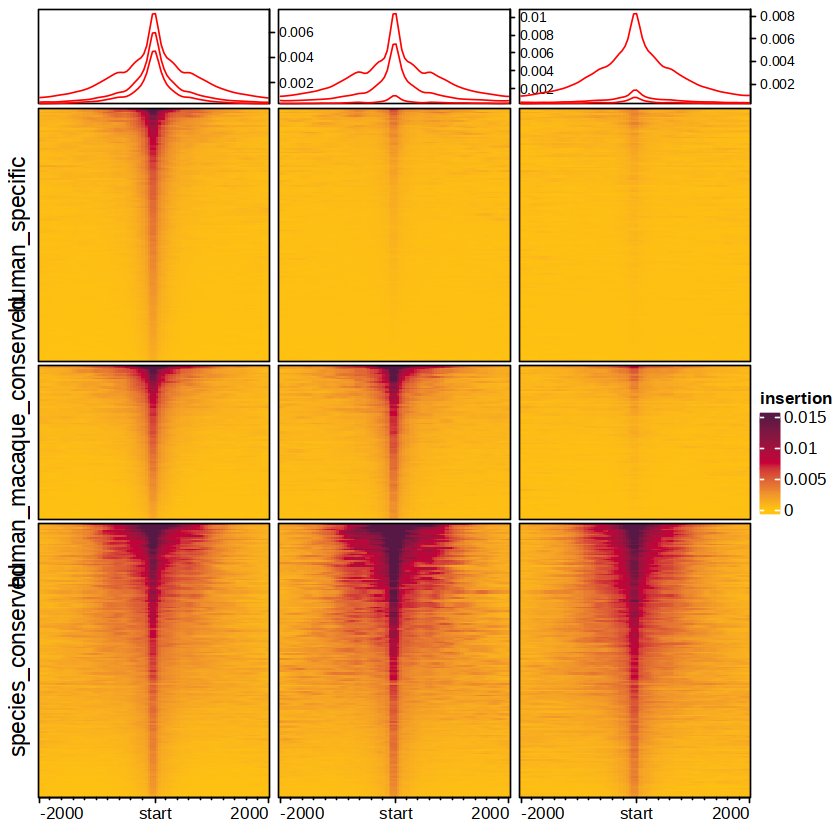

In [197]:
#plot
col_fun <- colorRamp2(breaks = c(0,0.0075,0.015),colors = c('#FFC30F','#C70039','#581845'))
EnrichedHeatmap(mat = p1@matrix,row_split = factor(group[rownames(p1@matrix)],levels = c('human_specific','human_macaque_conserved','species_conserved')),
                use_raster = TRUE,raster_resize_mat = mean,col = col_fun,name = 'insertion',pos_line = FALSE) + 
  EnrichedHeatmap(mat = p2@matrix,row_split = factor(group[rownames(p2@matrix)],levels = c('human_specific','human_macaque_conserved','species_conserved')),
                  use_raster = TRUE,raster_resize_mat = mean,col = col_fun,show_heatmap_legend = FALSE,pos_line = FALSE,row_order = p1@row_order) + 
  EnrichedHeatmap(mat = p3@matrix,row_split = factor(group[rownames(p3@matrix)],levels = c('human_specific','human_macaque_conserved','species_conserved')),
                  use_raster = TRUE,raster_resize_mat = mean,col = col_fun,show_heatmap_legend = FALSE,pos_line = FALSE,row_order = p1@row_order)

### create all cell type DAP

In [ ]:
#load data
Brain_ATAC_peak <- readRDS(file = './res/step_73_fig_221102/Brain_ATAC_peak.rds')
human_peak_matrix <- readRDS(file = './res/step_73_fig_221102/human_peak_matrix.rds')
macaque_peak_matrix <- readRDS(file = './res/step_73_fig_221102/macaque_peak_matrix.rds')
mouse_peak_matrix <- readRDS(file = './res/step_73_fig_221102/mouse_peak_matrix.rds')

Greenleaf_ATAC_ArchR <- loadArchRProject(path = './processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/')
macaque_multiome_ArchR <- loadArchRProject(path = './processed_data/221008_summary/macaque_multiome_ArchR_221011/')
mouse_multiome_ArchR <- loadArchRProject(path = './processed_data/221008_summary/mouse_multiome_ArchR_221009/')

color_param <- readRDS(file = './data/parameter/shared_param/MetaValue_color_param_220923.rds')

In [ ]:
#cell type list
cell_type_list <- names(color_param$celltype)
cell_type_list <- cell_type_list[c(cell_type_list %in% Greenleaf_ATAC_ArchR$cell_type)]
cell_type_list <- cell_type_list[c(cell_type_list %in% macaque_multiome_ArchR$cell_type)]
cell_type_list <- cell_type_list[c(cell_type_list %in% mouse_multiome_ArchR$Gex_macaque_cell_type)]

In [ ]:
#for loop
for(i in cell_type_list){

#set cell type
cell_type <- i
cell_type_dot <- gsub(pattern = '-',replacement = '.',x = cell_type,fixed = TRUE)

#create human pseudobulk
cell_list <- rownames(Greenleaf_ATAC_ArchR@cellColData)[c(Greenleaf_ATAC_ArchR$cell_type == cell_type)]
temp_num <- round(length(cell_list)/3)
cell_list <- split(x = cell_list,f = sample(c(rep('rep_1',times = temp_num),rep('rep_2',times = temp_num),rep('rep_3',times = length(cell_list) - 2*temp_num))))
human_cell_list <- cell_list

human_pseudo_bulk <- base::do.call(what = cbind,args = base::lapply(X = c('rep_1','rep_2','rep_3'),FUN = function(x){
    temp <- cell_list[[x]]
    temp <- rowSums(human_peak_matrix[,temp])
    return(temp)
}))
rownames(human_pseudo_bulk) <- rownames(human_peak_matrix)
colnames(human_pseudo_bulk) <- paste('human',cell_type_dot,c('rep_1','rep_2','rep_3'),sep = '#')
    
#create macaque pseudo bulk
cell_list <- rownames(macaque_multiome_ArchR@cellColData)[c(macaque_multiome_ArchR$cell_type == cell_type)]
temp_num <- round(length(cell_list)/3)
cell_list <- split(x = cell_list,f = sample(c(rep('rep_1',times = temp_num),rep('rep_2',times = temp_num),rep('rep_3',times = length(cell_list) - 2*temp_num))))
macaque_cell_list <- cell_list

macaque_pseudo_bulk <- base::do.call(what = cbind,args = base::lapply(X = c('rep_1','rep_2','rep_3'),FUN = function(x){
    temp <- cell_list[[x]]
    temp <- rowSums(macaque_peak_matrix[,temp])
    return(temp)
}))
rownames(macaque_pseudo_bulk) <- rownames(macaque_peak_matrix)
colnames(macaque_pseudo_bulk) <- paste('macaque',cell_type_dot,c('rep_1','rep_2','rep_3'),sep = '#')

#create mouse pseudo bulk
cell_list <- rownames(mouse_multiome_ArchR@cellColData)[c(mouse_multiome_ArchR$Gex_macaque_cell_type == cell_type)]
temp_num <- round(length(cell_list)/3)
cell_list <- split(x = cell_list,f = sample(c(rep('rep_1',times = temp_num),rep('rep_2',times = temp_num),rep('rep_3',times = length(cell_list) - 2*temp_num))))
mouse_cell_list <- cell_list

mouse_pseudo_bulk <- base::do.call(what = cbind,args = base::lapply(X = c('rep_1','rep_2','rep_3'),FUN = function(x){
    temp <- cell_list[[x]]
    temp <- rowSums(mouse_peak_matrix[,temp])
    return(temp)
}))
rownames(mouse_pseudo_bulk) <- rownames(mouse_peak_matrix)
colnames(mouse_pseudo_bulk) <- paste('mouse',cell_type_dot,c('rep_1','rep_2','rep_3'),sep = '#')

#create pseudobulk counts matrix
#macaque
temp <- Brain_ATAC_peak$macaque
names(temp) <- paste(temp@seqnames,as.character(temp@ranges),sep = '-')
rownames(macaque_pseudo_bulk) <- temp[c(rownames(macaque_pseudo_bulk))]$name
macaque_pseudo_bulk <- macaque_pseudo_bulk[c(rownames(human_pseudo_bulk)),]

#mouse
temp <- Brain_ATAC_peak$mouse
names(temp) <- paste(temp@seqnames,as.character(temp@ranges),sep = '-')
rownames(mouse_pseudo_bulk) <- temp[c(rownames(mouse_pseudo_bulk))]$name
mouse_pseudo_bulk <- mouse_pseudo_bulk[c(rownames(human_pseudo_bulk)),]

#filter peak list

#human peak list
peak_file <- list.files(path = './processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls',peak_file,sep = '/')
file.exists(peak_file)
peak_file <- readRDS(file = peak_file)

temp <- Brain_ATAC_peak$human
names(temp) <- paste(temp@seqnames,as.character(temp@ranges),sep = '-')
temp_num <- countOverlaps(query = temp,subject = peak_file)
temp <- temp[names(temp_num)[c(temp_num > 0)]]

peak_list <- names(temp)

#macaque peak list
peak_file <- list.files(path = './processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls',peak_file,sep = '/')
file.exists(peak_file)
peak_file <- readRDS(file = peak_file)

temp <- Brain_ATAC_peak$macaque
names(temp) <- paste(temp@seqnames,as.character(temp@ranges),sep = '-')
temp_num <- countOverlaps(query = temp,subject = peak_file)
temp <- temp[names(temp_num)[c(temp_num > 0)]]

peak_list <- c(peak_list,temp$name)

#mouse peak list
peak_file <- list.files(path = './processed_data/221008_summary/mouse_multiome_ArchR_221009/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/mouse_multiome_ArchR_221009/PeakCalls',peak_file,sep = '/')
file.exists(peak_file)
peak_file <- readRDS(file = peak_file)

temp <- Brain_ATAC_peak$mouse
names(temp) <- paste(temp@seqnames,as.character(temp@ranges),sep = '-')
temp_num <- countOverlaps(query = temp,subject = peak_file)
temp <- temp[names(temp_num)[c(temp_num > 0)]]

peak_list <- c(peak_list,temp$name)

#unique peak_list
peak_list <- unique(peak_list)

#DESeq2

#human macaque
dds_HR <- cbind(human_pseudo_bulk,macaque_pseudo_bulk)
dds_HR <- dds_HR[c(peak_list),]
dds <- dds_HR
meta_data <- do.call(what = cbind,args = base::lapply(X = c(1,2,3),FUN = function(x){
    temp <- strsplit(x = colnames(dds),split = '#')
    temp <- do.call(what = rbind,args = temp)
    return(temp[,x])
}))

rownames(meta_data) <- colnames(dds)
colnames(meta_data) <- c('species','cell_type','sample')

dds_HR <- DESeqDataSetFromMatrix(countData = dds,colData = meta_data,design = ~ species)
dds_HR <- DESeq(object = dds_HR)

#human mouse
dds_HM <- cbind(human_pseudo_bulk,mouse_pseudo_bulk)
dds_HM <- dds_HM[c(peak_list),]
dds <- dds_HM
meta_data <- do.call(what = cbind,args = base::lapply(X = c(1,2,3),FUN = function(x){
    temp <- strsplit(x = colnames(dds),split = '#')
    temp <- do.call(what = rbind,args = temp)
    return(temp[,x])
}))

rownames(meta_data) <- colnames(dds)
colnames(meta_data) <- c('species','cell_type','sample')

dds_HM <- DESeqDataSetFromMatrix(countData = dds,colData = meta_data,design = ~ species)
dds_HM <- DESeq(object = dds_HM)

#macaque mouse
dds_RM <- cbind(macaque_pseudo_bulk,mouse_pseudo_bulk)
dds_RM <- dds_RM[c(peak_list),]
dds <- dds_RM
meta_data <- do.call(what = cbind,args = base::lapply(X = c(1,2,3),FUN = function(x){
    temp <- strsplit(x = colnames(dds),split = '#')
    temp <- do.call(what = rbind,args = temp)
    return(temp[,x])
}))

rownames(meta_data) <- colnames(dds)
colnames(meta_data) <- c('species','cell_type','sample')

dds_RM <- DESeqDataSetFromMatrix(countData = dds,colData = meta_data,design = ~ species)
dds_RM <- DESeq(object = dds_RM)

#human specific
res_HR <- results(object = dds_HR,contrast = c('species','human','macaque'))
res_HR <- na.omit(res_HR)
res_HR <- res_HR[res_HR$log2FoldChange > 1 & res_HR$padj < 0.01,]

res_HM <- results(object = dds_HM,contrast = c('species','human','mouse'))
res_HM <- na.omit(res_HM)
res_HM <- res_HM[res_HM$log2FoldChange > 1 & res_HM$padj < 0.01,]

human_specific_peak <- dplyr::intersect(x = rownames(res_HR),y = rownames(res_HM))

#intersect with human peaklist
peak_file <- list.files(path = './processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls',peak_file,sep = '/')
file.exists(peak_file)
peak_file <- readRDS(file = peak_file)
temp <- Brain_ATAC_peak$human
names(temp) <- paste(temp@seqnames,as.character(temp@ranges),sep = '-')
temp_num <- countOverlaps(query = temp[c(human_specific_peak)],subject = peak_file)
human_specific_peak <- human_specific_peak[c(temp_num > 0)]

ii <- rep('human_specific',times = length(human_specific_peak))
names(ii) <- human_specific_peak
group <- ii

#human macaque conserved
res_HM <- results(object = dds_HM,contrast = c('species','human','mouse'))
res_HM <- na.omit(res_HM)
res_HM <- res_HM[res_HM$log2FoldChange > 1 & res_HM$padj < 0.01,]

res_RM <- results(object = dds_RM,contrast = c('species','macaque','mouse'))
res_RM <- na.omit(res_RM)
res_RM <- res_RM[res_RM$log2FoldChange > 1 & res_RM$padj < 0.01,]

res_HR <- results(object = dds_HR,contrast = c('species','human','macaque'))
res_HR <- na.omit(res_HR)
res_HR <- res_HR[abs(res_HR$log2FoldChange) <= 1,]

human_macaque_conserved_peak <- dplyr::intersect(x = rownames(res_HM),y = rownames(res_RM))
human_macaque_conserved_peak <- dplyr::intersect(x = human_macaque_conserved_peak,y = rownames(res_HR))

#intersect with human peaklist
peak_file <- list.files(path = './processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls',peak_file,sep = '/')
file.exists(peak_file)
peak_file <- readRDS(file = peak_file)
temp <- Brain_ATAC_peak$human
names(temp) <- paste(temp@seqnames,as.character(temp@ranges),sep = '-')
temp_num <- countOverlaps(query = temp[c(human_macaque_conserved_peak)],subject = peak_file)
human_macaque_conserved_peak <- human_macaque_conserved_peak[c(temp_num > 0)]

#intersect with macaque peaklist
peak_file <- list.files(path = './processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls',peak_file,sep = '/')
file.exists(peak_file)
peak_file <- readRDS(file = peak_file)
temp <- Brain_ATAC_peak$macaque
names(temp) <- temp$name
temp_num <- countOverlaps(query = temp[c(human_macaque_conserved_peak)],subject = peak_file)
human_macaque_conserved_peak <- human_macaque_conserved_peak[c(temp_num > 0)]

ii <- rep('human_macaque_conserved',times = length(human_macaque_conserved_peak))
names(ii) <- human_macaque_conserved_peak
group <- append(group,ii)

#species conserved
res_HM <- results(object = dds_HM,contrast = c('species','human','mouse'))
res_HM <- na.omit(res_HM)
res_HM <- res_HM[abs(res_HM$log2FoldChange) <= 1,]

res_RM <- results(object = dds_RM,contrast = c('species','macaque','mouse'))
res_RM <- na.omit(res_RM)
res_RM <- res_RM[abs(res_RM$log2FoldChange) <= 1,]

res_HR <- results(object = dds_HR,contrast = c('species','human','macaque'))
res_HR <- na.omit(res_HR)
res_HR <- res_HR[abs(res_HR$log2FoldChange) <= 1,]

species_conserved_peak <- dplyr::intersect(x = rownames(res_HM),y = rownames(res_RM))
species_conserved_peak <- dplyr::intersect(x = species_conserved_peak,y = rownames(res_HR))

#intersect with human peaklist
peak_file <- list.files(path = './processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls',peak_file,sep = '/')
file.exists(peak_file)
peak_file <- readRDS(file = peak_file)
temp <- Brain_ATAC_peak$human
names(temp) <- paste(temp@seqnames,as.character(temp@ranges),sep = '-')
temp_num <- countOverlaps(query = temp[c(species_conserved_peak)],subject = peak_file)
species_conserved_peak <- species_conserved_peak[c(temp_num > 0)]

#intersect with macaque peaklist
peak_file <- list.files(path = './processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls',peak_file,sep = '/')
file.exists(peak_file)
peak_file <- readRDS(file = peak_file)
temp <- Brain_ATAC_peak$macaque
names(temp) <- temp$name
temp_num <- countOverlaps(query = temp[c(species_conserved_peak)],subject = peak_file)
species_conserved_peak <- species_conserved_peak[c(temp_num > 0)]

#intersect with mouse peaklist
peak_file <- list.files(path = './processed_data/221008_summary/mouse_multiome_ArchR_221009/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/mouse_multiome_ArchR_221009/PeakCalls',peak_file,sep = '/')
file.exists(peak_file)
peak_file <- readRDS(file = peak_file)
temp <- Brain_ATAC_peak$mouse
names(temp) <- temp$name
temp_num <- countOverlaps(query = temp[c(species_conserved_peak)],subject = peak_file)
species_conserved_peak <- species_conserved_peak[c(temp_num > 0)]

ii <- rep('species_conserved',times = length(species_conserved_peak))
names(ii) <- species_conserved_peak
group <- append(group,ii)

#save data
char <- paste0('./res/step_74_fig_221103/',cell_type_dot,'_DAP_list_by_DESeq2.rds')
saveRDS(object = group,file = char)

#print done
char <- paste(cell_type,'done!',sep = ' ')
print(char)
}

### validate using Ex-3

In [ ]:
cell_type <- 'Ex-3'
cell_type_dot <- 'Ex.3'
group <- readRDS(file = './res/step_74_fig_221103/Ex.4_DAP_list_by_DESeq2.rds')

In [ ]:
#human
names(Brain_ATAC_peak$human) <- paste(Brain_ATAC_peak$human@seqnames,as.character(Brain_ATAC_peak$human@ranges),sep = '-')
temp <- as.character(Brain_ATAC_peak$human[names(group)]@ranges)
temp <- base::lapply(temp,function(x){
  a <- as.numeric(strsplit(x = x,split = '-')[[1]][1])
  b <- as.numeric(strsplit(x = x,split = '-')[[1]][2])
  c <- round(abs(b+a)/2,digits = 0)
  return(c)
})
temp <- unlist(temp)
temp <- paste0(Brain_ATAC_peak$human[names(group)]@seqnames,':',temp,'-',temp)
target_site <- as(temp,'GRanges')
names(target_site) <- names(group)

signal_coverage <- list.files(path = './res/step_35_fig_220606/Reads_In_Cell_Type_Peaks_coverage/human/')
signal_coverage <- signal_coverage[grep(pattern = cell_type_dot,x = signal_coverage,fixed = TRUE)]
signal_coverage <- paste('./res/step_35_fig_220606/Reads_In_Cell_Type_Peaks_coverage/human',signal_coverage,sep = '/')
signal_coverage <- rtracklayer::import.bw(con = signal_coverage)
mat <- normalizeToMatrix(signal = signal_coverage,target = target_site,extend = 2000,w = 50,limit = NA,
                         value_column = 'score',background = 0,mean_mode = 'w0',smooth = TRUE,verbose = TRUE)

p1 <- EnrichedHeatmap(mat = mat,row_split = factor(group[rownames(mat)],levels = c('human_specific','human_macaque_conserved','species_conserved')),
                      use_raster = TRUE,raster_resize_mat = mean)

In [ ]:
#macaque
names(Brain_ATAC_peak$macaque) <- Brain_ATAC_peak$macaque$name
temp <- as.character(Brain_ATAC_peak$macaque[names(group)]@ranges)
temp <- base::lapply(temp,function(x){
  a <- as.numeric(strsplit(x = x,split = '-')[[1]][1])
  b <- as.numeric(strsplit(x = x,split = '-')[[1]][2])
  c <- round(abs(b+a)/2,digits = 0)
  return(c)
})
temp <- unlist(temp)
temp <- paste0(Brain_ATAC_peak$macaque[names(group)]@seqnames,':',temp,'-',temp)
target_site <- as(temp,'GRanges')
names(target_site) <- names(group)

signal_coverage <- list.files(path = './res/step_35_fig_220606/Reads_In_Cell_Type_Peaks_coverage/macaque/')
signal_coverage <- signal_coverage[grep(pattern = cell_type_dot,x = signal_coverage,fixed = TRUE)]
signal_coverage <- paste('./res/step_35_fig_220606/Reads_In_Cell_Type_Peaks_coverage/macaque',signal_coverage,sep = '/')
signal_coverage <- rtracklayer::import.bw(con = signal_coverage)
mat <- normalizeToMatrix(signal = signal_coverage,target = target_site,extend = 2000,w = 50,limit = NA,
                         value_column = 'score',background = 0,mean_mode = 'w0',smooth = TRUE,verbose = TRUE)

p2 <- EnrichedHeatmap(mat = mat,row_split = factor(group[rownames(mat)],levels = c('human_specific','human_macaque_conserved','species_conserved')),
                      use_raster = TRUE,raster_resize_mat = mean)

p1+p2

In [ ]:
#mouse
names(Brain_ATAC_peak$mouse) <- Brain_ATAC_peak$mouse$name
temp <- as.character(Brain_ATAC_peak$mouse[names(group)]@ranges)
temp <- base::lapply(temp,function(x){
  a <- as.numeric(strsplit(x = x,split = '-')[[1]][1])
  b <- as.numeric(strsplit(x = x,split = '-')[[1]][2])
  c <- round(abs(b+a)/2,digits = 0)
  return(c)
})
temp <- unlist(temp)
temp <- paste0(Brain_ATAC_peak$mouse[names(group)]@seqnames,':',temp,'-',temp)
target_site <- as(temp,'GRanges')
names(target_site) <- names(group)

signal_coverage <- list.files(path = './res/step_35_fig_220606/Reads_In_Cell_Type_Peaks_coverage/mouse/')
signal_coverage <- signal_coverage[grep(pattern = cell_type_dot,x = signal_coverage,fixed = TRUE)]
signal_coverage <- paste('./res/step_35_fig_220606/Reads_In_Cell_Type_Peaks_coverage/mouse',signal_coverage,sep = '/')
signal_coverage <- rtracklayer::import.bw(con = signal_coverage)
mat <- normalizeToMatrix(signal = signal_coverage,target = target_site,extend = 2000,w = 50,limit = NA,
                         value_column = 'score',background = 0,mean_mode = 'w0',smooth = TRUE,verbose = TRUE)

p3 <- EnrichedHeatmap(mat = mat,row_split = factor(group[rownames(mat)],levels = c('human_specific','human_macaque_conserved','species_conserved')),
                      use_raster = TRUE,raster_resize_mat = mean)

p1+p2+p3

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



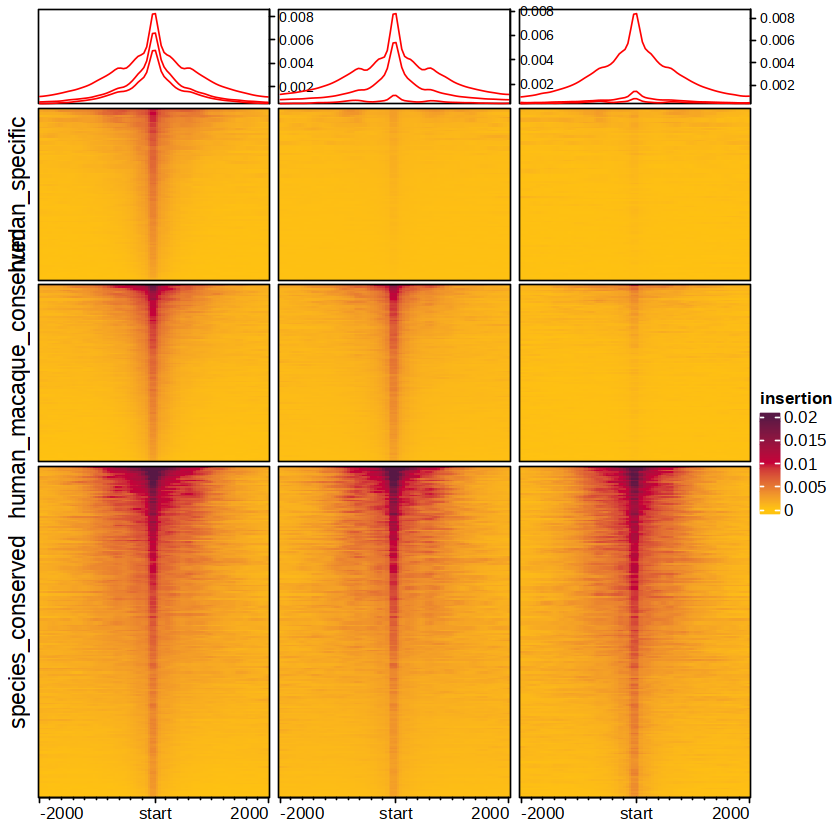

In [31]:
#plot
col_fun <- colorRamp2(breaks = c(0,0.01,0.02),colors = c('#FFC30F','#C70039','#581845'))
EnrichedHeatmap(mat = p1@matrix,row_split = factor(group[rownames(p1@matrix)],levels = c('human_specific','human_macaque_conserved','species_conserved')),
                use_raster = TRUE,raster_resize_mat = mean,col = col_fun,name = 'insertion',pos_line = FALSE) + 
  EnrichedHeatmap(mat = p2@matrix,row_split = factor(group[rownames(p2@matrix)],levels = c('human_specific','human_macaque_conserved','species_conserved')),
                  use_raster = TRUE,raster_resize_mat = mean,col = col_fun,show_heatmap_legend = FALSE,pos_line = FALSE,row_order = p1@row_order) + 
  EnrichedHeatmap(mat = p3@matrix,row_split = factor(group[rownames(p3@matrix)],levels = c('human_specific','human_macaque_conserved','species_conserved')),
                  use_raster = TRUE,raster_resize_mat = mean,col = col_fun,show_heatmap_legend = FALSE,pos_line = FALSE,row_order = p1@row_order)

## Use Wilcox method

In [ ]:
#load data
Brain_ATAC_peak <- readRDS(file = './res/step_73_fig_221102/Brain_ATAC_peak.rds')
human_peak_matrix <- readRDS(file = './res/step_73_fig_221102/human_peak_matrix.rds')
macaque_peak_matrix <- readRDS(file = './res/step_73_fig_221102/macaque_peak_matrix.rds')
mouse_peak_matrix <- readRDS(file = './res/step_73_fig_221102/mouse_peak_matrix.rds')
Greenleaf_ATAC_ArchR <- loadArchRProject(path = './processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/')
macaque_multiome_ArchR <- loadArchRProject(path = './processed_data/221008_summary/macaque_multiome_ArchR_221011/')
mouse_multiome_ArchR <- loadArchRProject(path = './processed_data/221008_summary/mouse_multiome_ArchR_221009/')

### IP as exmple

In [ ]:
#IP as example
cell_type <- 'IP'
cell_type_dot <- gsub(pattern = '-',replacement = '.',x = cell_type,fixed = TRUE)

In [ ]:
#filter peak list

#human peak list
peak_file <- list.files(path = './processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls',peak_file,sep = '/')
file.exists(peak_file)
peak_file <- readRDS(file = peak_file)

temp <- Brain_ATAC_peak$human
names(temp) <- paste(temp@seqnames,as.character(temp@ranges),sep = '-')
temp_num <- countOverlaps(query = temp,subject = peak_file)
temp <- temp[names(temp_num)[c(temp_num > 0)]]

peak_list <- names(temp)

#macaque peak list
peak_file <- list.files(path = './processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls',peak_file,sep = '/')
file.exists(peak_file)
peak_file <- readRDS(file = peak_file)

temp <- Brain_ATAC_peak$macaque
names(temp) <- paste(temp@seqnames,as.character(temp@ranges),sep = '-')
temp_num <- countOverlaps(query = temp,subject = peak_file)
temp <- temp[names(temp_num)[c(temp_num > 0)]]

peak_list <- c(peak_list,temp$name)

#mouse peak list
peak_file <- list.files(path = './processed_data/221008_summary/mouse_multiome_ArchR_221009/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/mouse_multiome_ArchR_221009/PeakCalls',peak_file,sep = '/')
file.exists(peak_file)
peak_file <- readRDS(file = peak_file)

temp <- Brain_ATAC_peak$mouse
names(temp) <- paste(temp@seqnames,as.character(temp@ranges),sep = '-')
temp_num <- countOverlaps(query = temp,subject = peak_file)
temp <- temp[names(temp_num)[c(temp_num > 0)]]

peak_list <- c(peak_list,temp$name)

#unique peak_list
peak_list <- unique(peak_list)

In [ ]:
#generate normalize factor
seq_depth_factor <- c(Greenleaf_ATAC_ArchR$ReadsInPeaks[c(Greenleaf_ATAC_ArchR$cell_type == cell_type)],
                      macaque_multiome_ArchR$ReadsInPeaks[c(macaque_multiome_ArchR$cell_type == cell_type)],
                      mouse_multiome_ArchR$ReadsInPeaks[c(mouse_multiome_ArchR$Gex_macaque_cell_type == cell_type)])
seq_depth_factor <- median(seq_depth_factor) * 10^4

In [ ]:
#normalize human peak matrix
cell_list <- rownames(Greenleaf_ATAC_ArchR@cellColData)[c(Greenleaf_ATAC_ArchR$cell_type == cell_type)]
human_peak_matrix_subset <- human_peak_matrix[c(peak_list),c(cell_list)] * seq_depth_factor

#normalize by reads in Peak
human_peak_matrix_subset <- base::do.call(what = cbind,args = base::lapply(X = cell_list,FUN = function(x){
    temp <- human_peak_matrix_subset[,x]/Greenleaf_ATAC_ArchR@cellColData[x,'ReadsInPeaks']
    return(temp)
}))
rownames(human_peak_matrix_subset) <- peak_list
colnames(human_peak_matrix_subset) <- cell_list

In [ ]:
#normalize macaque peak matrix
cell_list <- rownames(macaque_multiome_ArchR@cellColData)[c(macaque_multiome_ArchR$cell_type == cell_type)]
temp <- Brain_ATAC_peak$macaque
names(temp) <- temp$name
temp <- temp[c(peak_list)]
temp_peak_list <- paste(temp@seqnames,as.character(temp@ranges),sep = '-')
macaque_peak_matrix_subset <- macaque_peak_matrix[c(temp_peak_list),c(cell_list)] * seq_depth_factor

#normalize by reads in Peak
macaque_peak_matrix_subset <- base::do.call(what = cbind,args = base::lapply(X = cell_list,FUN = function(x){
    temp <- macaque_peak_matrix_subset[,x]/macaque_multiome_ArchR@cellColData[x,'ReadsInPeaks']
    return(temp)
}))
rownames(macaque_peak_matrix_subset) <- peak_list
colnames(macaque_peak_matrix_subset) <- cell_list

In [ ]:
#normalize mouse peak matrix
cell_list <- rownames(mouse_multiome_ArchR@cellColData)[c(mouse_multiome_ArchR$Gex_macaque_cell_type == cell_type)]
temp <- Brain_ATAC_peak$mouse
names(temp) <- temp$name
temp <- temp[c(peak_list)]
temp_peak_list <- paste(temp@seqnames,as.character(temp@ranges),sep = '-')
mouse_peak_matrix_subset <- mouse_peak_matrix[c(temp_peak_list),c(cell_list)] * seq_depth_factor

#normalize by reads in Peak
mouse_peak_matrix_subset <- base::do.call(what = cbind,args = base::lapply(X = cell_list,FUN = function(x){
    temp <- mouse_peak_matrix_subset[,x]/mouse_multiome_ArchR@cellColData[x,'ReadsInPeaks']
    return(temp)
}))
rownames(mouse_peak_matrix_subset) <- peak_list
colnames(mouse_peak_matrix_subset) <- cell_list

In [ ]:
#Wilcox test

#human vs macaque
res_HR <- my_sparseMatWilcoxon(mat1 = human_peak_matrix_subset,mat2 = macaque_peak_matrix_subset)

#human vs mouse
res_HM <- my_sparseMatWilcoxon(mat1 = human_peak_matrix_subset,mat2 = mouse_peak_matrix_subset)

#macaque vs mouse
res_RM <- my_sparseMatWilcoxon(mat1 = macaque_peak_matrix_subset,mat2 = mouse_peak_matrix_subset)

In [ ]:
#human specific
temp_res_HR <- res_HR[c(res_HR$log2FC > 1 & res_HR$fdr < 0.01),]
temp_res_HM <- res_HM[c(res_HM$log2FC > 1 & res_HM$fdr < 0.01),]

human_specific_peak <- dplyr::intersect(x = rownames(temp_res_HR),y = rownames(temp_res_HM))

#intersect with human peaklist
peak_file <- list.files(path = './processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls',peak_file,sep = '/')
file.exists(peak_file)
peak_file <- readRDS(file = peak_file)
temp <- Brain_ATAC_peak$human
names(temp) <- paste(temp@seqnames,as.character(temp@ranges),sep = '-')
temp_num <- countOverlaps(query = temp[c(human_specific_peak)],subject = peak_file)
human_specific_peak <- human_specific_peak[c(temp_num > 0)]

ii <- rep('human_specific',times = length(human_specific_peak))
names(ii) <- human_specific_peak
group <- ii

In [ ]:
#human macaque conserved
temp_res_HM <- res_HM[c(res_HM$log2FC > 1 & res_HM$fdr < 0.01),]
temp_res_RM <- res_RM[c(res_RM$log2FC > 1 & res_RM$fdr < 0.01),]
temp_res_HR <- res_HR[c(abs(res_HR$log2FC) <= 1),]

human_macaque_conserved_peak <- dplyr::intersect(x = rownames(temp_res_HR),y = rownames(temp_res_HM))
human_macaque_conserved_peak <- dplyr::intersect(x = human_macaque_conserved_peak,y = rownames(temp_res_RM))

#intersect with human peaklist
peak_file <- list.files(path = './processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls',peak_file,sep = '/')
file.exists(peak_file)
peak_file <- readRDS(file = peak_file)
temp <- Brain_ATAC_peak$human
names(temp) <- paste(temp@seqnames,as.character(temp@ranges),sep = '-')
temp_num <- countOverlaps(query = temp[c(human_macaque_conserved_peak)],subject = peak_file)
human_macaque_conserved_peak <- human_macaque_conserved_peak[c(temp_num > 0)]

#intersect with macaque peaklist
peak_file <- list.files(path = './processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls',peak_file,sep = '/')
file.exists(peak_file)
peak_file <- readRDS(file = peak_file)
temp <- Brain_ATAC_peak$macaque
names(temp) <- temp$name
temp_num <- countOverlaps(query = temp[c(human_macaque_conserved_peak)],subject = peak_file)
human_macaque_conserved_peak <- human_macaque_conserved_peak[c(temp_num > 0)]

ii <- rep('human_macaque_conserved',times = length(human_macaque_conserved_peak))
names(ii) <- human_macaque_conserved_peak
group <- append(group,ii)

In [ ]:
#species conserved
temp_res_HR <- res_HR[c(abs(res_HR$log2FC) <= 1),]
temp_res_HM <- res_HM[c(abs(res_HM$log2FC) <= 1),]
temp_res_RM <- res_RM[c(abs(res_RM$log2FC) <= 1),]

species_conserved_peak <- dplyr::intersect(x = rownames(temp_res_HR),y = rownames(temp_res_HM))
species_conserved_peak <- dplyr::intersect(x = species_conserved_peak,y = rownames(temp_res_RM))

#intersect with human peaklist
peak_file <- list.files(path = './processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/Greenleaf_ATAC_ArchR_221019/PeakCalls',peak_file,sep = '/')
file.exists(peak_file)
peak_file <- readRDS(file = peak_file)
temp <- Brain_ATAC_peak$human
names(temp) <- paste(temp@seqnames,as.character(temp@ranges),sep = '-')
temp_num <- countOverlaps(query = temp[c(species_conserved_peak)],subject = peak_file)
species_conserved_peak <- species_conserved_peak[c(temp_num > 0)]

#intersect with macaque peaklist
peak_file <- list.files(path = './processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/macaque_multiome_ArchR_221011/PeakCalls',peak_file,sep = '/')
file.exists(peak_file)
peak_file <- readRDS(file = peak_file)
temp <- Brain_ATAC_peak$macaque
names(temp) <- temp$name
temp_num <- countOverlaps(query = temp[c(species_conserved_peak)],subject = peak_file)
species_conserved_peak <- species_conserved_peak[c(temp_num > 0)]

#intersect with mouse peaklist
peak_file <- list.files(path = './processed_data/221008_summary/mouse_multiome_ArchR_221009/PeakCalls')
peak_file <- peak_file[c(grep(pattern = cell_type_dot,x = peak_file,fixed = TRUE))]
peak_file <- paste('./processed_data/221008_summary/mouse_multiome_ArchR_221009/PeakCalls',peak_file,sep = '/')
file.exists(peak_file)
peak_file <- readRDS(file = peak_file)
temp <- Brain_ATAC_peak$mouse
names(temp) <- temp$name
temp_num <- countOverlaps(query = temp[c(species_conserved_peak)],subject = peak_file)
species_conserved_peak <- species_conserved_peak[c(temp_num > 0)]

ii <- rep('species_conserved',times = length(species_conserved_peak))
names(ii) <- species_conserved_peak
group <- append(group,ii)

In [ ]:
#save data
char <- paste0('./res/step_74_fig_221103/',cell_type_dot,'_DAP_list_by_wilcox.rds')
saveRDS(object = group,file = char)

### validate by coverage plot

In [ ]:
#human
names(Brain_ATAC_peak$human) <- paste(Brain_ATAC_peak$human@seqnames,as.character(Brain_ATAC_peak$human@ranges),sep = '-')
temp <- as.character(Brain_ATAC_peak$human[names(group)]@ranges)
temp <- base::lapply(temp,function(x){
  a <- as.numeric(strsplit(x = x,split = '-')[[1]][1])
  b <- as.numeric(strsplit(x = x,split = '-')[[1]][2])
  c <- round(abs(b+a)/2,digits = 0)
  return(c)
})
temp <- unlist(temp)
temp <- paste0(Brain_ATAC_peak$human[names(group)]@seqnames,':',temp,'-',temp)
target_site <- as(temp,'GRanges')
names(target_site) <- names(group)

signal_coverage <- list.files(path = './res/step_35_fig_220606/Reads_In_Cell_Type_Peaks_coverage/human/')
signal_coverage <- signal_coverage[grep(pattern = cell_type_dot,x = signal_coverage,fixed = TRUE)]
signal_coverage <- paste('./res/step_35_fig_220606/Reads_In_Cell_Type_Peaks_coverage/human',signal_coverage,sep = '/')
signal_coverage <- rtracklayer::import.bw(con = signal_coverage)
mat <- normalizeToMatrix(signal = signal_coverage,target = target_site,extend = 2000,w = 50,limit = NA,
                         value_column = 'score',background = 0,mean_mode = 'w0',smooth = TRUE,verbose = TRUE)

p1 <- EnrichedHeatmap(mat = mat,row_split = factor(group[rownames(mat)],levels = c('human_specific','human_macaque_conserved','species_conserved')),
                      use_raster = TRUE,raster_resize_mat = mean)

In [ ]:
#macaque
names(Brain_ATAC_peak$macaque) <- Brain_ATAC_peak$macaque$name
temp <- as.character(Brain_ATAC_peak$macaque[names(group)]@ranges)
temp <- base::lapply(temp,function(x){
  a <- as.numeric(strsplit(x = x,split = '-')[[1]][1])
  b <- as.numeric(strsplit(x = x,split = '-')[[1]][2])
  c <- round(abs(b+a)/2,digits = 0)
  return(c)
})
temp <- unlist(temp)
temp <- paste0(Brain_ATAC_peak$macaque[names(group)]@seqnames,':',temp,'-',temp)
target_site <- as(temp,'GRanges')
names(target_site) <- names(group)

signal_coverage <- list.files(path = './res/step_35_fig_220606/Reads_In_Cell_Type_Peaks_coverage/macaque/')
signal_coverage <- signal_coverage[grep(pattern = cell_type_dot,x = signal_coverage,fixed = TRUE)]
signal_coverage <- paste('./res/step_35_fig_220606/Reads_In_Cell_Type_Peaks_coverage/macaque',signal_coverage,sep = '/')
signal_coverage <- rtracklayer::import.bw(con = signal_coverage)
mat <- normalizeToMatrix(signal = signal_coverage,target = target_site,extend = 2000,w = 50,limit = NA,
                         value_column = 'score',background = 0,mean_mode = 'w0',smooth = TRUE,verbose = TRUE)

p2 <- EnrichedHeatmap(mat = mat,row_split = factor(group[rownames(mat)],levels = c('human_specific','human_macaque_conserved','species_conserved')),
                      use_raster = TRUE,raster_resize_mat = mean)

p1+p2

In [ ]:
#mouse
names(Brain_ATAC_peak$mouse) <- Brain_ATAC_peak$mouse$name
temp <- as.character(Brain_ATAC_peak$mouse[names(group)]@ranges)
temp <- base::lapply(temp,function(x){
  a <- as.numeric(strsplit(x = x,split = '-')[[1]][1])
  b <- as.numeric(strsplit(x = x,split = '-')[[1]][2])
  c <- round(abs(b+a)/2,digits = 0)
  return(c)
})
temp <- unlist(temp)
temp <- paste0(Brain_ATAC_peak$mouse[names(group)]@seqnames,':',temp,'-',temp)
target_site <- as(temp,'GRanges')
names(target_site) <- names(group)

signal_coverage <- list.files(path = './res/step_35_fig_220606/Reads_In_Cell_Type_Peaks_coverage/mouse/')
signal_coverage <- signal_coverage[grep(pattern = cell_type_dot,x = signal_coverage,fixed = TRUE)]
signal_coverage <- paste('./res/step_35_fig_220606/Reads_In_Cell_Type_Peaks_coverage/mouse',signal_coverage,sep = '/')
signal_coverage <- rtracklayer::import.bw(con = signal_coverage)
mat <- normalizeToMatrix(signal = signal_coverage,target = target_site,extend = 2000,w = 50,limit = NA,
                         value_column = 'score',background = 0,mean_mode = 'w0',smooth = TRUE,verbose = TRUE)

p3 <- EnrichedHeatmap(mat = mat,row_split = factor(group[rownames(mat)],levels = c('human_specific','human_macaque_conserved','species_conserved')),
                      use_raster = TRUE,raster_resize_mat = mean)

p1+p2+p3

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



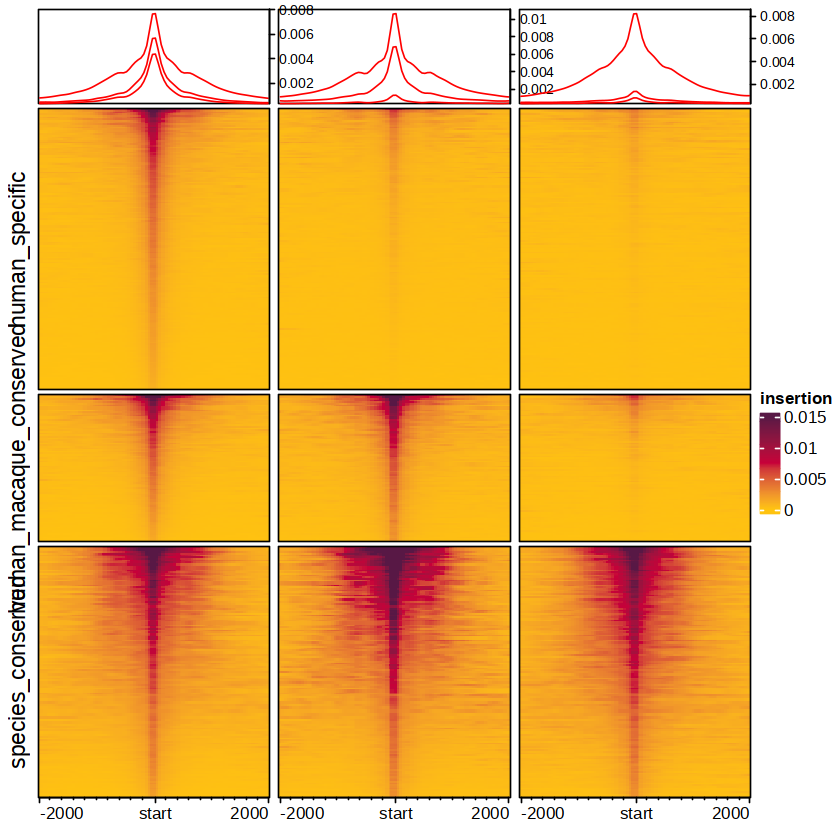

In [33]:
#plot
col_fun <- colorRamp2(breaks = c(0,0.0075,0.015),colors = c('#FFC30F','#C70039','#581845'))
EnrichedHeatmap(mat = p1@matrix,row_split = factor(group[rownames(p1@matrix)],levels = c('human_specific','human_macaque_conserved','species_conserved')),
                use_raster = TRUE,raster_resize_mat = mean,col = col_fun,name = 'insertion',pos_line = FALSE) + 
  EnrichedHeatmap(mat = p2@matrix,row_split = factor(group[rownames(p2@matrix)],levels = c('human_specific','human_macaque_conserved','species_conserved')),
                  use_raster = TRUE,raster_resize_mat = mean,col = col_fun,show_heatmap_legend = FALSE,pos_line = FALSE,row_order = p1@row_order) + 
  EnrichedHeatmap(mat = p3@matrix,row_split = factor(group[rownames(p3@matrix)],levels = c('human_specific','human_macaque_conserved','species_conserved')),
                  use_raster = TRUE,raster_resize_mat = mean,col = col_fun,show_heatmap_legend = FALSE,pos_line = FALSE,row_order = p1@row_order)